# Using cross entropy loss for the MNIST_SAMPLE dataset

**Objective:** As in the last notebook, I want to move towards classifying the full MNIST dataset of ten digits by first working with loss functions that can work with N activations from the final layer for the smaller MNIST_SAMPLE dataset. The MNIST_SAMPLE dataset has data only for two digits (3s and 7s). The loss functions I explored previously were the `mnist_loss`, `softmax_loss`, and `cross_entropy_loss`. However, at that time, I had been unable to successfully use `cross_entropy_loss` for this dataset and assumed that we could use `softmax_loss` instead as it seemed to work well.

Turns out that I was defining the `batch_accuracy` function incorrectly then. I learnt this the hard way when I tried scaling up from two to ten categories. The `softmax_loss` function was just not able to push the accuracy up. After some head-scratching and googling, I realized the book did not teach us precisely how to calculate the `batch_accuracy` for the case where the last layer has N activations corresponding to N categories. Fortunately, it is not that hard and I found a good reference [here](https://jonathan-sands.com/deep%20learning/fastai/pytorch/vision/classifier/2020/11/15/MNIST.html#Training-a-neural-network). The key looks to be to use the [`torch.max`](https://pytorch.org/docs/stable/generated/torch.max.html) function to select the column index with the maximum activation value and compare that to `y` (the dependent variable).

As before, the reference for everything in this blog post is the [fastai 2020 course](https://course.fast.ai), especially the [amazing textbook](https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527).

In this notebook, I learn how to use the `cross_entropy_loss` for the MNIST_SAMPLE dataset with two categories. Scaling up to ten categories from this point should be straight-forward from here and is the topic of my next notebook. 

### Get the basic imports out of the way

In [1]:
from fastai.vision.all import *

In [2]:
import fastbook
fastbook.setup_book()
from fastbook import *

### Get your data ready

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#4) [Path('/home/igolgi/.fastai/data/mnist_sample/valid'),Path('/home/igolgi/.fastai/data/mnist_sample/labels.csv'),Path('/home/igolgi/.fastai/data/mnist_sample/train'),Path('/home/igolgi/.fastai/data/mnist_sample/models')]

In [4]:
three_imgs = (path/'train'/'3').ls().sorted()
seven_imgs = (path/'train'/'7').ls().sorted()

three_tensors_list = [tensor(Image.open(img)) for img in three_imgs]
seven_tensors_list = [tensor(Image.open(img)) for img in seven_imgs]

stacked_threes = torch.stack(three_tensors_list).float()/255.
stacked_sevens = torch.stack(seven_tensors_list).float()/255.
stacked_threes.shape, stacked_sevens.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

<AxesSubplot:>

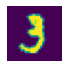

In [5]:
show_image(three_tensors_list[0])

<AxesSubplot:>

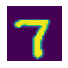

In [6]:
show_image(seven_tensors_list[0])

In [7]:
train_x = torch.cat([stacked_threes, stacked_sevens]); train_x.shape

torch.Size([12396, 28, 28])

So, in the training data, there are a total of 12396 images of 28x28 pixels for the 3s and 7s. Lets "flatten" the 28x28 matrix into one long row of 784 pixel values.

In [8]:
train_x = train_x.view(-1, 28*28); train_x.shape

torch.Size([12396, 784])

So, now, we have 12396 rows of 784 pixel values per image as part of the training dataset. Let us create the labels for each of these images so that a label of 1 corresponds to 3s and a label of 0 corresponds to a 7. This is the same as with the `mnist_loss` function in the textbook.

In [10]:
train_y = tensor( [1]*len(three_imgs) + [0]*len(seven_imgs) ).unsqueeze(1); train_y.shape

torch.Size([12396, 1])

Now, we perform the same set of actions for the validation dataset. 

In [11]:
valid_three_imgs = (path/'valid'/'3').ls().sorted()
valid_seven_imgs = (path/'valid'/'7').ls().sorted()

valid_three_tensors_list = [tensor(Image.open(img)) for img in valid_three_imgs]
valid_seven_tensors_list = [tensor(Image.open(img)) for img in valid_seven_imgs]

valid_stacked_threes = torch.stack(valid_three_tensors_list).float()/255.
valid_stacked_sevens = torch.stack(valid_seven_tensors_list).float()/255.
valid_stacked_threes.shape, valid_stacked_sevens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Let's flatten the validation dataset (28x28 images) into rows of 784 pixels. And let's create labels the same way we did for the training data, i.e. 1 to represent 3s and 0 to represent 7s.

In [12]:
valid_x = torch.cat([valid_stacked_threes, valid_stacked_sevens]).view(-1, 28*28); valid_x.shape

torch.Size([2038, 784])

In [13]:
valid_y = tensor( [1]*len(valid_three_imgs) + [0]*len(valid_seven_imgs) ).unsqueeze(1); valid_y.shape

torch.Size([2038, 1])

### Prepare the dataset and dataloaders

In [14]:
dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

In [15]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
dls = DataLoaders(dl, valid_dl)

### Get a basic linear classifier going as well as the loss functions, optimizers and metric functions

In [16]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [17]:
def linear1(xb, weights, bias): return xb@weights + bias # linear classifier with one weight per pixel

In [18]:
def mnist_loss(preds, tgts):
    preds = preds.sigmoid()
    return torch.where(tgts==1, 1-preds, preds).mean()

In [19]:
def cross_entropy_loss(preds, tgts):
    preds = torch.log_softmax(preds, dim=1)
    #print(preds.shape, preds[0], preds[:,0].shape[0])
    return F.nll_loss(preds, torch.squeeze(tgts))

In [20]:
def calc_grad_mnist_loss(xb, yb, model, params):
    preds = model(xb, params[0], params[1])
    loss = mnist_loss(preds, yb)
    loss.backward()

In [21]:
def calc_grad_ce_loss(xb, yb, model, params):
    preds = model(xb, params[0], params[1])
    loss = cross_entropy_loss(preds, yb)
    #print(loss)
    loss.backward()

In [22]:
def step_weights(params, lr):
    for p in params:
        p.data -= p.grad*lr
        p.grad.zero_()

In [23]:
def train_epoch(model, lr, params, calc_grad_func):
    for xb,yb in dl:
        calc_grad_func(xb,yb,model,params)
        step_weights(params,lr)

### How do we define the batch_accuracy function? Let us look at a small batch and work it out

Let us work with 4 of the input images in the first batch. We want to walk through the process of looking at the images (x), the labels (y), the weights and biases in the linear model function/classifier we use, and the predictions returned by the model. 

In [32]:
x,y = dl.one_batch()

In [33]:
x.shape, y.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [34]:
w = init_params((28*28,2)); b = init_params(2); w.shape, b.shape

(torch.Size([784, 2]), torch.Size([2]))

In [38]:
x[:4].shape, w[:4].shape

(torch.Size([4, 784]), torch.Size([4, 2]))

In [57]:
acts = linear1(x[:4], w, b); acts[:,0].shape[0]

4

In [58]:
acts

tensor([[-10.7714,  -4.5953],
        [-13.9319,   0.0812],
        [ -2.5972,  -5.2215],
        [-17.7803,  10.3004]], grad_fn=<AddBackward0>)

### Interpreting the activations from the linear model

`acts` is the activations from the "final" layer in our model here. Note that there are two columns  of activations. So, what meaning can we assign to these two columns and to the two values in each row? 

Well, each column corresponds to the activation score for each category. And **in each row, we should pick the index corresponding to the maximum value as the category that is predicted**. This matches what the textbook says about how to interpret multi-column activations.

So, for example, in the `acts` tensor above,
- in row 0, the maximum value is -4.5953 and this corresponds to index 1. This means the predicted value is 1
- in row 1, the maximum value is 0.0812 and this corresponds to index 1. This means the predicted value is 1
- and so on

The final prediction here should be [1,1,0,1]. This prediction can then be compared against the `y` to calculate the batch_accuracy. 

In [43]:
y[:4]

tensor([[1],
        [1],
        [1],
        [1]])

In PyTorch, the `torch.max` function can return a tuple with the maximum value in each row as well as the index location of this maximum value. 

In [59]:
max_acts,preds = torch.max(acts, 1); max_acts, preds

(tensor([-4.5953,  0.0812, -2.5972, 10.3004], grad_fn=<MaxBackward0>),
 tensor([1, 1, 0, 1]))

The accuracy is then simply the mean of the `preds` tensor above compared to `y`.

In [60]:
correct = (preds == torch.squeeze(y[:4])); correct

tensor([ True,  True, False,  True])

In [62]:
correct.float(), correct.float().mean()

(tensor([1., 1., 0., 1.]), tensor(0.7500))

This is how we calculate the batch_accuracy when there are N columns of activations from the final layer corresponding to the N categories. The basic idea is that, in each row, the model, when trained well, should try and push up the value corresponding to the correct class up higher and the remaining values lower (when using the `cross_entropy` loss function). The index corresponding to the maximum value will then match the correct category.

In [63]:
def batch_accuracy(xb,yb, mnist=True, print_debug=False):
    if mnist:
        preds = xb.sigmoid()
        correct = (preds>0.5) == yb
    else:
        acts,preds = torch.max(xb, 1)
        yb_squeezed = torch.squeeze(yb)
        if print_debug:
            print(xb, acts, preds, yb_squeezed)
        #print(xb.shape, yb.shape, preds.shape, yb_squeezed.shape)
        correct = (preds == yb_squeezed)
    return correct.float().mean()

In [65]:
batch_accuracy(acts, y[:4], False, True)

tensor([[-10.7714,  -4.5953],
        [-13.9319,   0.0812],
        [ -2.5972,  -5.2215],
        [-17.7803,  10.3004]], grad_fn=<AddBackward0>) tensor([-4.5953,  0.0812, -2.5972, 10.3004], grad_fn=<MaxBackward0>) tensor([1, 1, 0, 1]) tensor([1, 1, 1, 1])


tensor(0.7500)

We can use the same `validate_epoch` function as we used earlier with `mnist_loss`. The notebook cells below just walk through what `torch.stack` does with the list of batch_accuracy values computed per epoch for each mini-batch in the validation dataset.

In [71]:
accs = [tensor(0.75), tensor(0.25), tensor(0.35), tensor(0.85)]; accs

[tensor(0.7500), tensor(0.2500), tensor(0.3500), tensor(0.8500)]

In [72]:
torch.stack(accs)

tensor([0.7500, 0.2500, 0.3500, 0.8500])

In [73]:
tensor(accs)

tensor([0.7500, 0.2500, 0.3500, 0.8500])

In [74]:
def validate_epoch(model, params, mnist=True, print_debug=False):
    accs = [batch_accuracy(model(xb, params[0], params[1]), yb, mnist, print_debug) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

### Now, lets use mnist_loss and one column of activations

In [75]:
weights = init_params((28*28,1))
bias = init_params(1)
lr = 1.0
params = [weights, bias]
for i in range(10):
    train_epoch(linear1, lr, params, calc_grad_mnist_loss)
    print(validate_epoch(linear1, params), end=' ')

0.5791 0.7846 0.8843 0.9131 0.9292 0.9414 0.9487 0.9531 0.956 0.958 

### Now let's use cross_entropy_loss and two columns of activations

In [78]:
weights = init_params((28*28,2))
bias = init_params(2)
lr = 1.0 
params = [weights, bias]
print(weights.shape, bias.shape)
for i in range(10):
    train_epoch(linear1, lr, params, calc_grad_ce_loss)
    print(validate_epoch(linear1, params, False), end=' ')

torch.Size([784, 2]) torch.Size([2])
0.5083 0.9048 0.9438 0.9512 0.9555 0.956 0.9585 0.9614 0.9619 0.9624 

### Conclusion

I am able to use the traditional `cross_entropy_loss` using the negative log-likelihood function to work as expected with the MNIST_SAMPLE dataset of '3's and '7's and two columns of activations from the final layer. In the previous notebook, I could not do so due to my inability to define the `batch_accuracy` function correctly. The key looks to be to use the [`torch.max`](https://pytorch.org/docs/stable/generated/torch.max.html) function to select the column index with the maximum activation value and compare that to `y` (the dependent variable).

### Now, let's replace our code with PyTorch/fastai built-in functions and see if we get the same result

In [38]:
linear2 = nn.Linear(28*28, 2)
w,b = linear2.parameters(); w.shape, b.shape

(torch.Size([2, 784]), torch.Size([2]))

Lets put our step_weights function into a class

In [39]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr
        
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr
    
    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [40]:
opt = BasicOptim(linear2.parameters(), lr)

Lets redefine our loss functions to match the template expected by fastai and PyTorch. Lets also redefine the `train_epoch` function to use the optimizer defined above.

In [41]:
def calc_grad_mnist_loss(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
    return loss

In [42]:
def calc_grad_ce_loss(xb, yb, model):
    preds = model(xb)
    loss = cross_entropy_loss(preds, yb)
    #print(loss)
    loss.backward()
    return loss

In [43]:
def train_epoch(model, calc_grad_func):
    epoch_loss = []
    for xb,yb in dl:
        epoch_loss.append(calc_grad_func(xb,yb,model))
        opt.step()
        opt.zero_grad()
    epoch_loss_tnsr = tensor(epoch_loss)
    return epoch_loss_tnsr.mean()

We need to redefine the validate_epoch function simply because we don't need to pass the params as args to the built-in Pytorch function

In [44]:
def validate_epoch_new(model, mnist=True):
    accs = [batch_accuracy(model(xb), yb, mnist) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [45]:
validate_epoch_new(linear2, False)

0.6663

In [46]:
train_epoch(linear2, calc_grad_ce_loss)

tensor(0.5787)

In [47]:
def train_model(model, epochs, mnist=True):
    for i in range(epochs):
        if mnist:
            epoch_loss_mean = train_epoch(model, calc_grad_mnist_loss)
        else:
            epoch_loss_mean = train_epoch(model, calc_grad_ce_loss)
        #print(epoch_loss_mean)
        print(validate_epoch_new(model, mnist), end=' ')

In [48]:
# mnist_loss
lr = 1.
linear2 = nn.Linear(28*28,1)
#opt = SGD(linear2.parameters(), lr)
opt = BasicOptim(linear2.parameters(), lr)
train_model(linear2, 10, True)

0.4932 0.8047 0.8452 0.9126 0.9336 0.9468 0.9551 0.9619 0.9663 0.9668 

In [49]:
# softmax_loss
lr = 1e-2
linear3 = nn.Linear(28*28,2)
#opt = SGD(linear3.parameters(), lr)
opt = BasicOptim(linear3.parameters(), lr)
train_model(linear3, 10, False)

0.5269 0.8877 0.938 0.955 0.9633 0.9643 0.9638 0.9663 0.9658 0.9668 

A simple replacement we can make for our BasicOptim optimizer class is to replace it with the built-in SGD optimizer function

In [50]:
# mnist_loss
lr = 1.
linear2 = nn.Linear(28*28,1)
opt = SGD(linear2.parameters(), lr)
train_model(linear2, 10, True)

0.4932 0.4932 0.6807 0.874 0.9204 0.9355 0.9512 0.958 0.9638 0.9658 

In [51]:
# softmax_loss
lr = 1e-2
linear3 = nn.Linear(28*28,2)
opt = SGD(linear3.parameters(), lr)
train_model(linear3, 10, False)

0.5444 0.8984 0.9399 0.9575 0.9638 0.9648 0.9648 0.9653 0.9658 0.9663 

Instead of `train_model`, we can now transition over to using the built-in `Learner.fit` class method. Before we do this, lets redefine batch_accuracy for mnist and softmax separately as there is a need to follow the template here for this method

In [52]:
def batch_accuracy_mnist(xb,yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [53]:
def batch_accuracy_ce(xb,yb):
    _,preds = torch.max(xb, 1)
    yb_squeezed = torch.squeeze(yb)
    #print(xb.shape, yb.shape, preds.shape, yb_squeezed.shape)
    correct = (preds == yb_squeezed)
    return correct.float().mean()

In [54]:
learn_mnist = Learner(dls, nn.Linear(28*28,1), opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy_mnist)

In [60]:
learn_ce = Learner(dls, nn.Linear(28*28,2), opt_func=SGD, loss_func=cross_entropy_loss, metrics=batch_accuracy_ce)

In [57]:
learn_mnist.fit(10, lr=1.0)

epoch,train_loss,valid_loss,batch_accuracy_mnist,time
0,0.636874,0.503316,0.495584,00:00
1,0.462960,0.232174,0.795388,00:00
2,0.172324,0.162464,0.853778,00:00
3,0.076681,0.099876,0.917566,00:00
4,0.041421,0.074306,0.935721,00:00
5,0.027634,0.060111,0.949951,00:00
6,0.021947,0.051175,0.956820,00:00
7,0.019395,0.045197,0.963690,00:00
8,0.018082,0.040978,0.966143,00:00
9,0.017282,0.037855,0.968597,00:00


In [61]:
learn_ce.fit(10, lr=1e-2)

epoch,train_loss,valid_loss,batch_accuracy_ce,time
0,0.275928,0.691266,0.508832,00:00
1,0.218829,0.307219,0.883709,00:00
2,0.172936,0.202616,0.936703,00:00
3,0.144097,0.161210,0.954858,00:00
4,0.125797,0.139614,0.963199,00:00
5,0.113691,0.126365,0.965162,00:00
6,0.105253,0.117359,0.966143,00:00
7,0.099056,0.110794,0.965653,00:00
8,0.094285,0.105764,0.966634,00:00
9,0.090465,0.101761,0.966143,00:00


### Using a neural network instead of a linear classifier

In [62]:
simple_net_mnist = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1) # 1 column of activations from the final layer
)

In [63]:
simple_net_ce = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,2) # 2 columns of activations from the final layer
)

In [64]:
learn_mnist = Learner(dls, simple_net_mnist, opt_func=SGD, loss_func=mnist_loss, metrics=batch_accuracy_mnist)

In [65]:
learn_softmax = Learner(dls, simple_net_ce, opt_func=SGD, loss_func=cross_entropy_loss, metrics=batch_accuracy_ce)

In [66]:
learn_mnist.fit(20, 0.1)

epoch,train_loss,valid_loss,batch_accuracy_mnist,time
0,0.361355,0.396705,0.512758,00:00
1,0.163877,0.249748,0.778214,00:00
2,0.088437,0.121506,0.909715,00:00
3,0.056420,0.080100,0.939647,00:00
4,0.041769,0.061811,0.956330,00:00
5,0.034433,0.051752,0.963199,00:00
6,0.030325,0.045476,0.965162,00:00
7,0.027719,0.041226,0.966634,00:00
8,0.025876,0.038150,0.969578,00:00
9,0.024465,0.035804,0.970559,00:00


In [67]:
learn_ce.fit(20, 1e-2)

epoch,train_loss,valid_loss,batch_accuracy_ce,time
0,0.085444,0.098483,0.967125,00:00
1,0.083706,0.095735,0.968597,00:00
2,0.081895,0.093388,0.969087,00:00
3,0.080118,0.091353,0.970069,00:00
4,0.078438,0.089565,0.970559,00:00
5,0.076881,0.087976,0.971050,00:00
6,0.075449,0.086552,0.971050,00:00
7,0.074135,0.085264,0.971050,00:00
8,0.072925,0.084091,0.972031,00:00
9,0.071808,0.083017,0.972031,00:00


### Pretty cool accuracy numbers there! :-)